# Carbon Project 16S Analysis

## Preprocessing

In [1]:
!pip install ../SeREGen

Processing /Users/NikhilKalidasu/Documents/DNA Visualization/SeREGen/SeREGen
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for SeREGen: filename=SeREGen-0.1.1-py3-none-any.whl size=48020 sha256=74f99aff868e2c93628df7e04472d3f9dfe2badc82b5b525b56dd7572710644b
  Stored in directory: /private/var/folders/_t/pfxf9f7x0nz1m6vckn9glz_40000gn/T/pip-ephem-wheel-cache-kcunen2c/wheels/c6/79/e5/431bc1fc7477a043b52c65c69a40862e34f24b12add06f2e4c
Successfully built SeREGen
  Attempting uninstall: SeREGen
    Found existing installation: SeREGen 0.1.1
    Uninstalling SeREGen-0.1.1:
      Successfully uninstalled SeREGen-0.1.1

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
mapping_file = pd.read_csv('MappingFile_CarbonProject_FNA_June_21_2024.tsv', delimiter='\t')
# old_mapping_file = pd.read_csv('MappingFile_CarbonProject_FNA.tsv', delimiter='\t')
taxonomy = pd.read_excel('Carbon Project Taxonomy GB123_tax_gtdbtk2.3.2_ref214.xlsx')
from SeREGen.pipeline import DNASequencePipeline
p = DNASequencePipeline()
p.load_dataset(['full_16s_carbon_extracted_06272024.fna'])

INFO: Using pytorch backend
INFO: Enabling RDKit 2024.03.1 jupyter extensions


In [3]:
mapping_file = pd.read_csv('MappingFile_CarbonProject_FNA_June_21_2024.tsv', delimiter='\t')
old_mapping_file = pd.read_csv('MappingFile_CarbonProject_FNA.tsv', delimiter='\t')
new_bins = mapping_file.loc[mapping_file['Bin'] != old_mapping_file['Bin']]

In [4]:
all_headers = p.dataset['raw_headers'].apply(lambda i: i.split(':')[2])
mapping_file_only_16s = mapping_file[mapping_file['Original Contig Name'].isin(all_headers)]
taxonomy['Bin'] = taxonomy['user_genome']
combined_df = mapping_file_only_16s.merge(taxonomy, how='inner', on='Bin')

In [5]:
binned_contigs = combined_df['Original Contig Name'].to_numpy().astype(str)

In [6]:
import numpy as np
from SeREGen.dataset_builder import HeaderParser
def carbon_tax_extractor(header: str):
    contig_name = header.split(':')[2]
    postfix = contig_name.find('_clean')
    if postfix != -1:
        contig_name = contig_name[:postfix]
    if contig_name not in binned_contigs:
        return ['UNBINNED'] * 7
    tax = combined_df[combined_df['Original Contig Name'] == contig_name]['classification'].iloc[0]
    result = [i[i.rfind('_')+1:] for i in tax.split(';')]
    return np.array([('NOVEL' if not i else i) for i in result])
# %timeit carbon_tax_extractor(sample)
carbon_header_parser = HeaderParser(carbon_tax_extractor,
                                    ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus',
                                     'Species'])

In [7]:
from SeREGen.pipeline import DNASequencePipeline
p = DNASequencePipeline()
p.load_dataset(['full_16s_carbon.fna'], header_parser=carbon_header_parser)

In [8]:
p.dataset['labels'].apply(lambda i: i[0] == 'UNBINNED').sum() / len(p.dataset)

0.7249014824544943

In [12]:
import torch
p.create_model(res='low', embed_dist='hyperbolic', norm_type='soft_clip', dist_args={'jobs': 2, 'chunksize': 1024},
               float_type=torch.float32, use_embedding_layer=False, force_dtype=True, repr_size=3)
# p.model.model = p.model.model.to(torch.float32)

In [13]:
p.fit(suppress_grad_warn=["vanishing", "nan"], epoch_factor=2, loss="r2", epochs=1)

Preprocessing dataset...


100%|████████████████████████████████████████| 10658/10658 [00:00<00:00, 13070.82it/s]


Epoch 1:


Training model (loss: 4.2430e-01):  21%|██▋          | 27/128 [00:07<00:28,  3.50it/s]


KeyboardInterrupt: 

In [16]:
results = p.evaluate()

Calculating embedding distances
Calculating true distances


100%|███████████████████████████████████████████████████████████████████████████| 21316/21316 [00:04<00:00, 4873.81it/s]

Mean squared error of distances: 0.7346523166503369
R-squared correlation coefficient: 0.8636526557087156


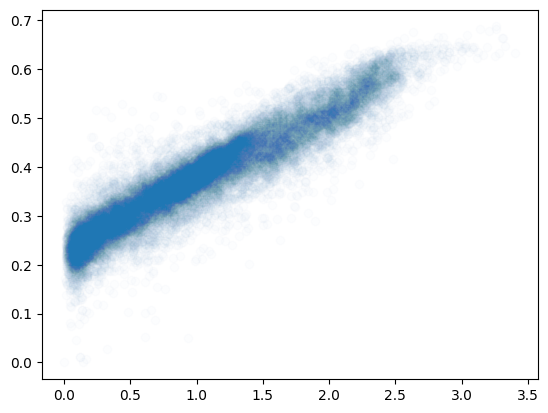

In [17]:
import matplotlib.pyplot as plt
plt.scatter(results[0], results[1], alpha=.01)
plt.show()

In [18]:
p.save('medium_carbon_corr_coef')

In [19]:
p = DNASequencePipeline.load('medium_carbon_corr_coef')
p.load_dataset(['full_16s_carbon.fna'], header_parser=carbon_header_parser)

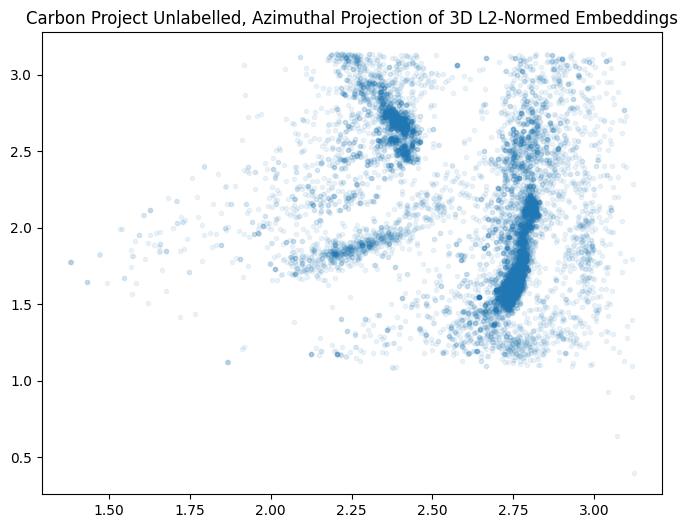

In [43]:
from SeREGen.visualize import reprs_by_theta_unlabelled
reprs_by_theta_unlabelled(p.reprs, title="Carbon Project Unlabelled, Azimuthal Projection of 3D L2-Normed Embeddings", savepath='out.png', alpha=.08)

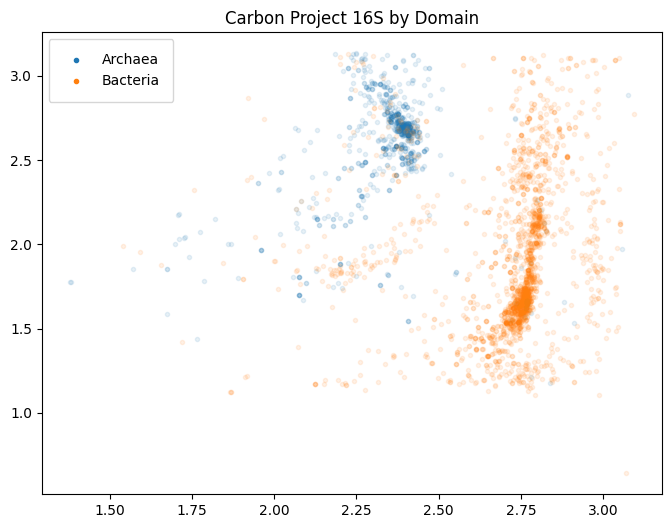

In [44]:
from SeREGen.visualize import reprs_by_theta_labelled
reprs_by_theta_labelled(p.reprs, p.dataset, 'Domain', 'Carbon Project 16S by Domain', mask=p.dataset['labels'].apply(lambda i: i[0] != 'UNBINNED').to_numpy())

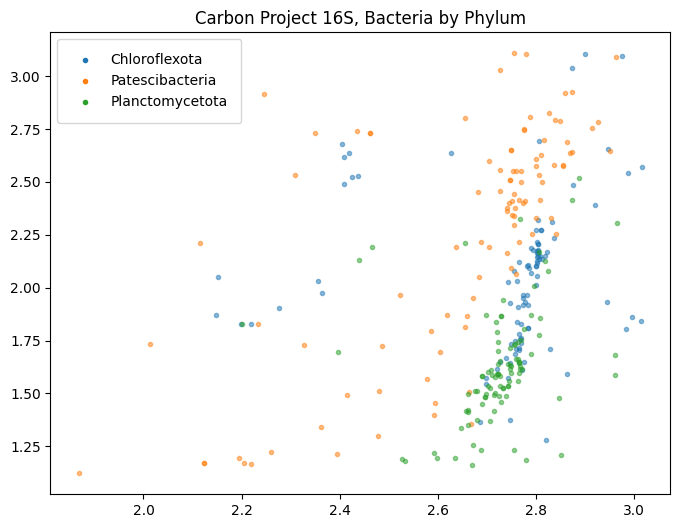

In [28]:
reprs_by_theta_labelled(p.reprs, p.dataset, 'Phylum', 'Carbon Project 16S, Bacteria by Phylum', mask=p.dataset['labels'].label_mask('Domain', 'Bacteria'),
                        filter=100, alpha=.5)

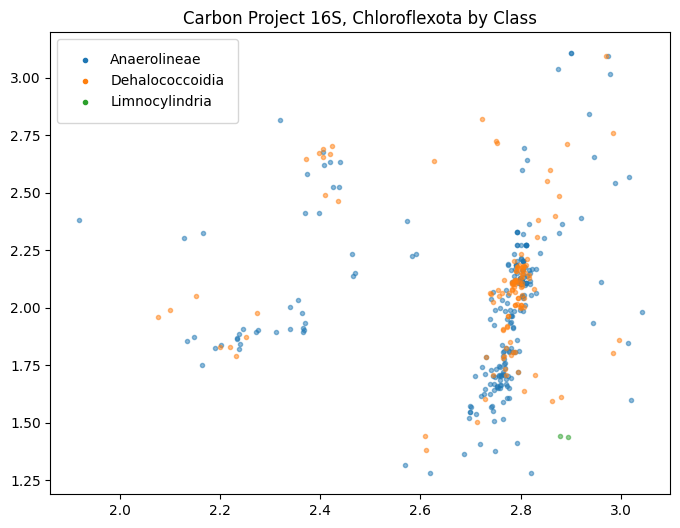

In [45]:
reprs_by_theta_labelled(p.reprs, p.dataset, 'Class', 'Carbon Project 16S, Chloroflexota by Class', mask=p.dataset['labels'].label_mask('Phylum', 'Chloroflexota'),
                        alpha=.5)

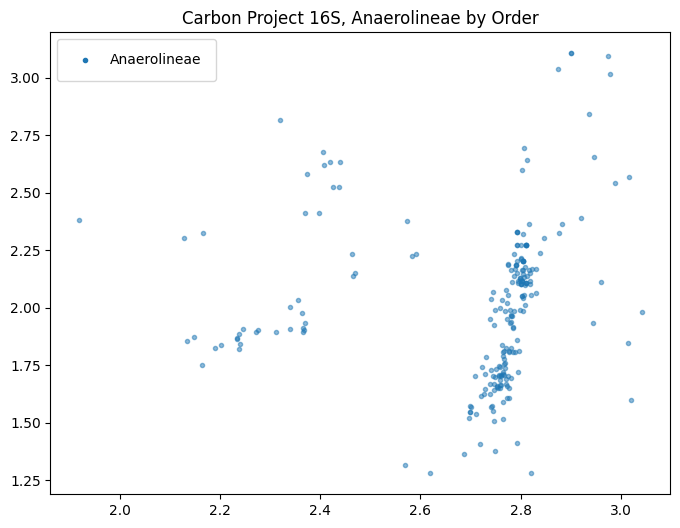

In [42]:
reprs_by_theta_labelled(p.reprs, p.dataset, 'Class', 'Carbon Project 16S, Anaerolineae by Order', mask=p.dataset['labels'].label_mask('Class', 'Anaerolineae'),
                        alpha=.5)